<a href="https://colab.research.google.com/github/AanLetna7025/Fly_Booking/blob/main/FlyTicketBooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langchain_google_genai langchain_core typing langgraph

In [4]:
import os
import csv
import uuid
from datetime import datetime
from typing import TypedDict
from google.colab import userdata
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai

In [ ]:
api_key = userdata.get('gemini_key')
genai.configure(api_key=api_key)
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", google_api_key=api_key)

# Folder & CSV path
folder = "/content/data"
os.makedirs(folder, exist_ok=True)
file_path = os.path.join(folder, "bookings.csv")

# Typed State
class BookingState(TypedDict, total=False):
    action: str
    name: str
    origin: str
    destination: str
    date: str   # YYYY-MM-DD
    ticket_id: str


In [7]:
print("\n📄 Contents of bookings.csv:")
!cat /content/data/bookings.csv


📄 Contents of bookings.csv:
Ticket ID,Name,Origin,Destination,Date
7feeac54,tina,dubai,oman,2025-08-03


In [ ]:

# Helpers
def ensure_csv_header() -> None:
    if not os.path.isfile(file_path) or os.path.getsize(file_path) == 0:
        with open(file_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["Ticket ID", "Name", "Origin", "Destination", "Date"])

def valid_date(s: str) -> bool:
    try:
        datetime.strptime(s, "%Y-%m-%d")
        return True
    except Exception:
        return False

def generate_ticket_id() -> str:
    return str(uuid.uuid4())[:8]

#  Nodes
def save_booking(state: BookingState) -> BookingState:
    ensure_csv_header()
    ticket_id = state.get("ticket_id") or generate_ticket_id()
    state["ticket_id"] = ticket_id

    name = state.get("name", "")
    origin = state.get("origin", "")
    destination = state.get("destination", "")
    date = state.get("date", "")

    with open(file_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([ticket_id, name, origin, destination, date])

    print(f"\n✅ Booking saved! Ticket ID: {ticket_id}")
    return state

def delete_ticket(state: BookingState) -> BookingState:
    ensure_csv_header()
    ticket_id = state.get("ticket_id")
    if not ticket_id:
        ticket_id = input("Enter Ticket ID to delete: ").strip()

    rows, deleted = [], False
    with open(file_path, mode="r", newline="") as file:
        reader = csv.reader(file)
        try:
            header = next(reader)
        except StopIteration:
            print("❌ CSV is empty.")
            return state
        for row in reader:
            if row and row[0] != ticket_id:
                rows.append(row)
            else:
                deleted = True

    with open(file_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(rows)

    if deleted:
        print(f"🗑️ Ticket {ticket_id} deleted.")
    else:
        print("❌ Ticket not found.")
    return state

def list_bookings(state: BookingState) -> BookingState:
    if not os.path.isfile(file_path) or os.path.getsize(file_path) == 0:
        print("\n📄 No bookings yet.")
        return state
    print("\n📋 Current bookings:")
    with open(file_path, mode="r", newline="") as file:
        reader = csv.reader(file)
        for i, row in enumerate(reader):
            print(", ".join(row) if i > 0 else " | ".join(row))
    return state

def booking_node(state: BookingState) -> BookingState:
    state["name"] = state.get("name") or input("Name: ").strip()
    state["origin"] = state.get("origin") or input("Origin: ").strip()
    state["destination"] = state.get("destination") or input("Destination: ").strip()

    if not state.get("date"):
        while True:
            d = input("Date (YYYY-MM-DD): ").strip()
            if valid_date(d):
                state["date"] = d
                break
            else:
                print("❗ Invalid date format, try again.")
    return save_booking(state)

def deletion_node(state: BookingState) -> BookingState:
    return delete_ticket(state)

def router_node(state: BookingState) -> BookingState:
    action = (state.get("action") or "").strip().lower()
    state["action"] = action
    return state

def finish_node(state: BookingState) -> BookingState:
    print("\n✅ Process finished.")
    return state

# graph
graph = StateGraph(BookingState)
graph.add_node("router", router_node)
graph.add_node("book_ticket", booking_node)
graph.add_node("delete_ticket", deletion_node)
graph.add_node("list_bookings", list_bookings)
graph.add_node("finish", finish_node)

graph.add_edge("__start__", "router")
graph.add_conditional_edges("router", lambda s: s.get("action"), {
    "book": "book_ticket",
    "delete": "delete_ticket",
    "list": "list_bookings"
})
graph.add_edge("book_ticket", "finish")
graph.add_edge("delete_ticket", "finish")
graph.add_edge("list_bookings", "finish")
graph.add_edge("finish", END)

app = graph.compile()


def call_compiled_graph(compiled, state: BookingState):
    for name in ("run", "execute", "start", "invoke", "__call__"):
        if hasattr(compiled, name):
            return getattr(compiled, name)(state)
    if hasattr(compiled, "call"):
        return compiled.call(state)
    raise RuntimeError("No runnable method found on compiled graph.")


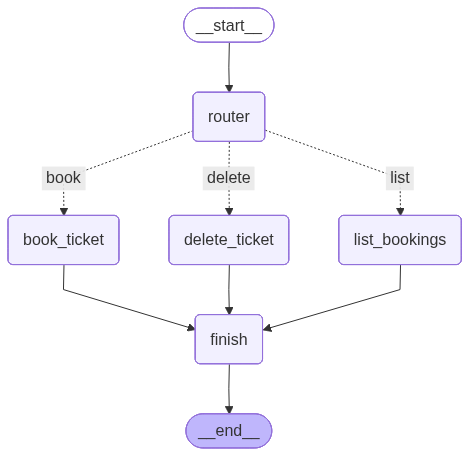

In [6]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [5]:

# CLI
def main_cli():
    print("=== Flight Ticket Booking (Gemini + LangGraph) ===")
    while True:
        action = input("\nEnter action (book/delete/list/exit): ").strip().lower()
        if action == "exit":
            print("👋 Goodbye!")
            break
        init_state: BookingState = {"action": action}
        try:
            result = call_compiled_graph(app, init_state)
            print("Result:", result)
        except Exception as e:
            print("🚨 Error:", e)

if __name__ == "__main__":
    main_cli()


=== Flight Ticket Booking (Gemini + LangGraph) ===

Enter action (book/delete/list/exit): list

📄 No bookings yet.

✅ Process finished.
Result: {'action': 'list'}

Enter action (book/delete/list/exit): book
Name: tina
Origin: dubai
Destination: oman
Date (YYYY-MM-DD): 2025-08-03

✅ Booking saved! Ticket ID: 7feeac54

✅ Process finished.
Result: {'action': 'book', 'name': 'tina', 'origin': 'dubai', 'destination': 'oman', 'date': '2025-08-03', 'ticket_id': '7feeac54'}

Enter action (book/delete/list/exit): book
Name: jeena
Origin: kochi
Destination: banglore
Date (YYYY-MM-DD): 2025-09-04

✅ Booking saved! Ticket ID: 1cc100a5

✅ Process finished.
Result: {'action': 'book', 'name': 'jeena', 'origin': 'kochi', 'destination': 'banglore', 'date': '2025-09-04', 'ticket_id': '1cc100a5'}

Enter action (book/delete/list/exit): list

📋 Current bookings:
Ticket ID | Name | Origin | Destination | Date
7feeac54, tina, dubai, oman, 2025-08-03
1cc100a5, jeena, kochi, banglore, 2025-09-04

✅ Process fin